In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random
from collections import Counter
import cv2
import matplotlib.pyplot as plt 
from datetime import datetime
import json

In [2]:
train_df = pd.read_csv('train.csv')
sample = pd.read_csv('sample_submission.csv')

# Get Boxing Info

In [3]:
with open('whale_faces.json', encoding='utf-8') as data_file:
    box_data = json.loads(data_file.read())

In [4]:
box_data[0]['annotations'][0]

{'class': 'Head',
 'height': 661.4783999999997,
 'type': 'rect',
 'width': 825.2927999999999,
 'x': 340.0703999999999,
 'y': 659.4047999999998}

In [5]:
bb_json = {}
for i in range(len(box_data)):
    filename = box_data[i]['filename'].split('/')[-1]
    try:
        bb_json[filename] = box_data[i]['annotations'][0]
    except:
        print(i,filename)

2926 w_7077.jpg


In [6]:
!pwd

/home/ec2-user/whales2


In [7]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [8]:
issue = read_image('/home/ec2-user/whales2/imgs/w_7077.jpg')

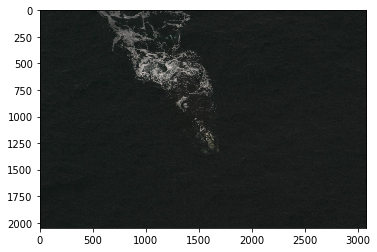

In [9]:
plt.imshow(issue)

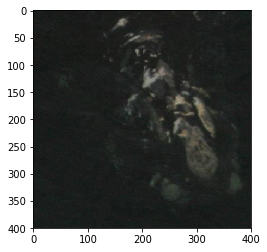

In [10]:
plt.imshow(issue[1000:1400,1300:1700])

In [11]:
bb_json['w_7077.jpg'] = {'class': 'Head',
 'height': 400,
 'type': 'rect',
 'width': 400,
 'x': 1300,
 'y': 1000}

In [12]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

# Get Y

In [13]:
# this will give us what we need to add the encoded y
y_id_to_num = {}
y_num_to_id = {}
uniq_y = sample.columns[1:] #this way they are in order of needed submission
for i in range(len(uniq_y)):
    y_id_to_num[uniq_y[i]] = i
    y_num_to_id[i] = uniq_y[i]

# add an encoded version of the y to dataframe
train_df['y'] = train_df["whaleID"].map(y_id_to_num)
#dictionary of image name to label
name_id_dict = dict( zip( train_df["Image"], train_df["y"]))

In [14]:
def get_Y(path, label2ind):
    """Given an image path get y"""
    im_name = path.parts[-1]
    im_class = label2ind[im_name]
    if im_name in bb_json:
        x = bb_json[im_name]
        return np.array([x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width'], im_class])
    return np.array([0.0, 0.0, 0.0, 0.0, im_class])

In [15]:
def get_bb(files, label2ind):
    return [get_Y(p, label2ind) for p in files]

# Transforms with bounding boxes

In [16]:
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [17]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)


In [18]:
def make_bb_px(y, s):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = s #s is shape of x
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [19]:
def resize_images_ratio(im, sz=300, r=1.75):
    sz2 = int(r*sz)
    return cv2.resize(im, (sz2, sz))

In [20]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [21]:
def random_cropXY(x, Y, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    x = crop(x, start_r, start_c, target_r, target_c)
    Y = crop(Y, start_r, start_c, target_r, target_c)
    return x, Y

In [22]:
def get_shape_original_images(org_path):
    files = list(org_path.iterdir())
    shapes = {f.parts[-1]: cv2.imread(str(f)).shape for f in files}
    return shapes

In [23]:
PATH = Path('/home/ec2-user/whales2/')

In [ ]:
shapes = get_shape_original_images(PATH/'imgs')

In [24]:
import pickle

In [25]:
shapes = pickle.load(open('shapes','rb'))

In [26]:
def transformsXY(path, bb, transforms, shape_x, sz):
    sz2 = int(sz*1.778)
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    # make Y with the original size of x
    Y = make_bb_px(bb, shape_x)
    if transforms:
        # already resized to 300
        #x = resize_images_ratio(x, sz+20)
        Y = resize_images_ratio(Y, 300)
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y, sz, sz2)
    else:
        x = resize_images_ratio(x, sz)
        Y = resize_images_ratio(Y, sz)
    return x, to_bb(Y)

In [27]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

In [28]:
# testing
train_path=PATH/"train-300"
files = list(train_path.iterdir())
test = files[:2]

In [29]:
test

[PosixPath('/home/ec2-user/whales2/train-300/w_1458.jpg'),
 PosixPath('/home/ec2-user/whales2/train-300/w_1195.jpg')]

In [30]:
bbs = get_bb(test, name_id_dict)
bbs

[array([ 599.15529179, 1108.43728982, 1291.51251786, 1754.19354875,
         131.        ]),
 array([ 625.78441587, 1181.66738103,  991.93487197, 1604.4047258 ,
         278.        ])]

In [31]:
im = cv2.imread(str(test[1]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
bb = bbs[1][:4]
bb

array([ 625.78441587, 1181.66738103,  991.93487197, 1604.4047258 ])

In [32]:
Y = make_bb_px(bb, shapes["w_1195.jpg"])
Y = resize_images_ratio(Y, 300)
bb0 = to_bb(Y)
bb0

array([114., 252., 179., 341.], dtype=float32)

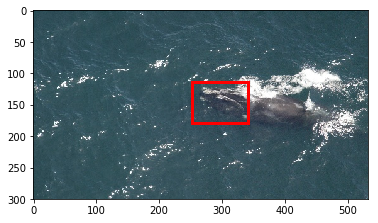

In [33]:
show_corner_bb(im, bb0)

In [34]:
im, bb_t = transformsXY(str(test[1]), bb, True, shapes["w_1195.jpg"], sz=280)

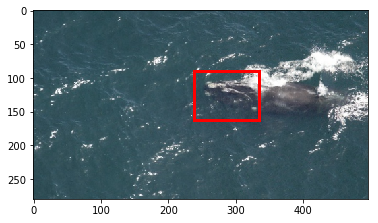

In [35]:
show_corner_bb(im, bb_t)

# New Dataset

In [36]:
def get_files(path=PATH/"train-300"):
    files = list(path.iterdir())
    names = [f.parts[-1] for f in files]
    labels = [name_id_dict[n] for n in names]
    return files, labels

In [37]:
train_files, y_train = get_files()
valid_files, y_valid = get_files(PATH/"valid-300")

In [38]:
class WhaleDataset(Dataset):
    def __init__(self, files, y, shapes, transforms=False, sz=280):
        self.transforms = transforms
        self.sz = sz
        self.files = files
        self.y = get_bb(self.files, name_id_dict)
        self.shapes = shapes
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        shape = self.shapes[path.parts[-1]]
        y = self.y[idx]
        bb = y[:4]
        x, y_bb = transformsXY(path, bb, self.transforms, shape, self.sz)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y[4], y_bb

In [39]:
train_ds = WhaleDataset(train_files, y_train, shapes, transforms=True)
valid_ds = WhaleDataset(valid_files, y_valid, shapes)

In [40]:
x, y_class, y_bb= train_ds[20]
x.shape, y_class, y_bb

((3, 280, 497), 171.0, array([149., 208., 213., 293.], dtype=float32))

In [41]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [42]:
x.shape

(3, 280, 497)

In [43]:
x,y,bb = next(iter(valid_dl))

In [44]:
x.shape

torch.Size([64, 3, 280, 490])

In [45]:
# 3x3 conv 32
conv1 = nn.Conv2d(3,32, kernel_size=(3,3))
# 3x3 conv 64
conv2 = nn.Conv2d(32,64, kernel_size=(3,3))
#3x3 conv 64
conv3 = nn.Conv2d(64,64, kernel_size=(3,3))
# 3x3 conv 128
conv4 = nn.Conv2d(64,128, kernel_size=(3,3))        
#3x3 cov 128
conv5 = nn.Conv2d(128,128, kernel_size=(3,3))
#3x3 cov 256
conv6 = nn.Conv2d(128,256, kernel_size=(3,3))
#3x3 cov 256
conv7 = nn.Conv2d(256,256, kernel_size=(3,3))
#3x3 cov 256
conv8 = nn.Conv2d(256,256, kernel_size=(3,3))

# pooling
pool = nn.MaxPool2d(kernel_size=3)


In [46]:
x = x.float()

In [47]:
x = conv1(x)
x = pool(x)
x = conv2(x)
x = pool(x)
x = conv3(x)
x = conv4(x)
x = conv5(x)
x = pool(x)
x = conv6(x)
x = conv7(x)
x = conv8(x)
x = x.view(x.size(0), -1)


In [48]:
dim = x.size(1)

In [49]:
#fully connected
fc1 = nn.Linear(dim,447) #class
fc2 = nn.Linear(dim,4) #bb

In [50]:
x_class = fc1(x)
x_bb = fc2(x)

In [51]:
x_class.shape

torch.Size([64, 447])

In [52]:
x_bb.shape

torch.Size([64, 4])

# Model

In [53]:
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        # 3x3 conv 32
        self.conv1 = nn.Conv2d(3,32, kernel_size=(3,3))
        # 3x3 conv 64
        self.conv2 = nn.Conv2d(32,64, kernel_size=(3,3))
        #3x3 conv 64
        self.conv3 = nn.Conv2d(64,64, kernel_size=(3,3))
        # 3x3 conv 128
        self.conv4 = nn.Conv2d(64,128, kernel_size=(3,3))        
        #3x3 cov 128
        self.conv5 = nn.Conv2d(128,128, kernel_size=(3,3))
        #3x3 cov 256
        self.conv6 = nn.Conv2d(128,256, kernel_size=(3,3))
        #3x3 cov 256
        self.conv7 = nn.Conv2d(256,256, kernel_size=(3,3))
        #3x3 cov 256
        self.conv8 = nn.Conv2d(256,256, kernel_size=(3,3))
        # pooling
        self.pool = nn.MaxPool2d(kernel_size=3)
        #fully connected
        #self.fc1 = nn.Linear(dim,447) #class
        #self.fc2 = nn.Linear(dim,4) #bb
 
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(x.size(0), -1)
        dim = x.size(1)
        fc1 = nn.Linear(dim,447).cuda()
        x_class = fc1(x)
        fc2 = nn.Linear(dim,4).cuda()
        x_bb = fc2(x)
        return x_class, x_bb

In [54]:
myNet = MyNet().cuda()

In [55]:
x, y1, y2 = next(iter(train_dl))

In [56]:
x.shape

torch.Size([64, 3, 280, 497])

In [57]:
y1 = y1.cuda()
y2 = y2.cuda()
out_class, out_bb = myNet(x.float().cuda())

In [58]:
y1.long()

tensor([ 287,  357,  123,  149,  266,   86,  319,  252,   31,  326,
         275,  167,  320,   39,   52,  328,  390,  231,  135,  104,
         329,  341,  330,  236,  269,  119,  161,  429,  346,   62,
          66,  346,   90,  416,  380,  385,  134,   43,  325,  182,
         129,  435,  167,  317,  321,  127,   47,   62,  360,  172,
         229,   55,  203,  163,  379,  307,  222,   89,  241,   31,
         218,  183,  299,  369], device='cuda:0')

In [59]:
out_class

tensor([[ 2.0057e-04,  5.2417e-03,  9.1910e-03,  ...,  3.7054e-03,
          1.6476e-02, -1.7557e-03],
        [ 1.1405e-02,  3.3882e-03,  4.6554e-03,  ..., -2.6179e-03,
          1.4591e-02,  2.5494e-03],
        [ 1.0919e-02,  7.0883e-03,  4.8036e-03,  ...,  1.0244e-03,
          1.6560e-02,  8.1284e-04],
        ...,
        [ 2.0284e-02, -5.7935e-03,  6.6452e-03,  ...,  3.7159e-03,
          2.2745e-02,  9.3391e-03],
        [ 6.0352e-03,  1.6930e-03,  4.5154e-03,  ..., -5.9023e-03,
          1.2291e-02,  1.6513e-03],
        [ 1.5712e-02,  2.2582e-03,  5.5922e-03,  ..., -6.1022e-03,
          1.2336e-02,  5.7339e-03]], device='cuda:0')

In [60]:
F.cross_entropy(out_class, y1.long()) #label prediction

tensor(6.1033, device='cuda:0')

In [61]:
F.l1_loss(out_bb, y2.float()).item() #bounding box prediction

192.5487518310547

# Triangluar Training Loop

In [100]:
def get_optimizer(model, lr=0.01, wd=0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [109]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-25, lr_high=.01, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x, y_class, y_bb in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss = F.cross_entropy(out_class, y_class)
            loss += F.l1_loss(out_bb, y_bb)/1000.0
            optim.zero_grad()
            loss.backward()
            losses.append(loss.item())
            ind +=1

    load_model(model, str(p))
    return lrs, losses

In [110]:
net = MyNet().cuda()
lrs, losses = LR_range_finder(net, train_dl)

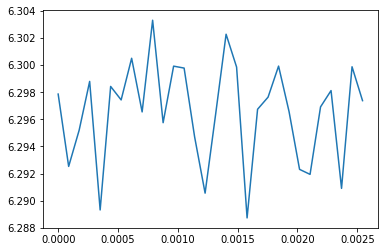

In [111]:
plt.plot(lrs[:30], losses[:30])
plt.show()

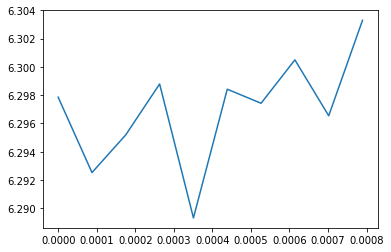

In [112]:
plt.plot(lrs[:10], losses[:10])
plt.show()

# Learning rate finder

In [113]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [114]:
def get_triangular_lr(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [115]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5,
                             lr_high=0.01):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss = F.cross_entropy(out_class, y_class)
            loss += F.l1_loss(out_bb, y_bb)/1000.0
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [116]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y_class, y_bb) in enumerate(valid_dl):
        batch = y_class.shape[0]
        
        x = x.cuda().float()
        y_class = y_class.cuda().long()
        y_bb = y_bb.cuda().float()
        out_class, out_bb = model(x)
        loss = F.cross_entropy(out_class, y_class)
        loss += F.l1_loss(out_bb, y_bb)/1000.0
        _, pred = torch.max(out_class, 1)
        correct += pred.eq(y_class).sum().item()
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss %.3f and accuracy %.3f" % (sum_loss/total, correct/total))

In [117]:
def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.01):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [118]:
net = MyNet().cuda()

In [119]:
val_metrics(net, valid_dl)

val loss 6.295 and accuracy 0.004


In [120]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-15, lr_high=.0001)

train loss 6.297
val loss 6.296 and accuracy 0.002
train loss 6.297
val loss 6.297 and accuracy 0.003
train loss 6.298
val loss 6.296 and accuracy 0.002
train loss 6.298
val loss 6.294 and accuracy 0.002
----End of step Time elapsed 0:06:49.738502


In [121]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-15, lr_high=.0001)

train loss 6.298
val loss 6.296 and accuracy 0.002
train loss 6.298
val loss 6.295 and accuracy 0.000
train loss 6.297
val loss 6.296 and accuracy 0.003
train loss 6.295
val loss 6.295 and accuracy 0.002
----End of step Time elapsed 0:06:48.604318


In [122]:
training_loop(net, train_dl, valid_dl, steps=1, lr_low=1e-15, lr_high=.0001)

train loss 6.297
val loss 6.295 and accuracy 0.007
train loss 6.297
val loss 6.294 and accuracy 0.007
train loss 6.298
val loss 6.296 and accuracy 0.001
train loss 6.296
val loss 6.298 and accuracy 0.002
----End of step Time elapsed 0:06:45.130517


In [124]:
def train_model(model, train_dl, valid_dl, lr=0.01, epochs =10):
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y_class, y_bb) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lr, wd =0)
            batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda().long()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            loss = F.cross_entropy(out_class, y_class)
            loss += F.l1_loss(out_bb, y_bb)/1000.0
            optim.zero_grad()
            loss.backward()
            optim.step()
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss %.3f" % (sum_loss/total))
        val_metrics(model, valid_dl)
    return sum_loss/total

In [ ]:
net0 = MyNet().cuda()
train_model(net0, train_dl=train_dl, valid_dl=valid_dl, lr=0.01, epochs =5)

train loss 856070.431
val loss 1210039.491 and accuracy 0.001
train loss 998028.335
val loss 979567.151 and accuracy 0.000
train loss 923414.097
val loss 659819.836 and accuracy 0.001


In [128]:
net1 = MyNet().cuda()
train_model(net1, train_dl=train_dl, valid_dl=valid_dl, lr=0.001, epochs =5)

train loss 6.352
val loss 6.308 and accuracy 0.001
train loss 6.342
val loss 6.311 and accuracy 0.003
train loss 6.369
val loss 6.311 and accuracy 0.003
train loss 6.358
val loss 6.452 and accuracy 0.002
train loss 6.359
val loss 6.357 and accuracy 0.001


6.358614635152352

In [125]:
net2 = MyNet().cuda()
train_model(net2, train_dl=train_dl, valid_dl=valid_dl, lr=0.0001, epochs =5)

train loss 6.298
val loss 6.295 and accuracy 0.002
train loss 6.297
val loss 6.298 and accuracy 0.002
train loss 6.298
val loss 6.295 and accuracy 0.002
train loss 6.298
val loss 6.294 and accuracy 0.002
train loss 6.298
val loss 6.298 and accuracy 0.001


6.297744950720247

In [126]:
net3 = MyNet().cuda()
train_model(net3, train_dl=train_dl, valid_dl=valid_dl, lr=0.00001, epochs =5)

train loss 6.297
val loss 6.297 and accuracy 0.001
train loss 6.297
val loss 6.295 and accuracy 0.002
train loss 6.297
val loss 6.297 and accuracy 0.007
train loss 6.297
val loss 6.295 and accuracy 0.001
train loss 6.297
val loss 6.297 and accuracy 0.002


6.29655960340928

In [127]:
net4 = MyNet().cuda()
train_model(net4, train_dl=train_dl, valid_dl=valid_dl, lr=0.000001, epochs =5)

train loss 6.297
val loss 6.296 and accuracy 0.000
train loss 6.298
val loss 6.297 and accuracy 0.000
train loss 6.297
val loss 6.296 and accuracy 0.002
train loss 6.297
val loss 6.296 and accuracy 0.002
train loss 6.296
val loss 6.295 and accuracy 0.004


6.296306368734054

# Getting Predictions

In [ ]:
class WhaleDatasetTest(Dataset):
    def __init__(self, files,sz=280):
        self.sz = sz
        self.files = files
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        path = self.files[idx]
        x = cv2.imread(str(path)).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        x = resize_images_ratio(x, self.sz)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x

In [ ]:
def final_pred(model, test_dl):
    model.eval()
    predictions = []
    for i, (x) in enumerate(test_dl):
        x = x.cuda().float()
        out_class, out_bb = model(x)
        predictions.append(out_class)
    return predictions

In [ ]:
test_files = list((PATH/"test-300").iterdir())
test_ds = WhaleDatasetTest(test_files)

batch_size = 64
test_dl = DataLoader(test_ds, batch_size=batch_size)

In [ ]:
predictions1 = final_pred(net, test_dl)
predictions2 = final_pred(net2, test_dl)

In [ ]:
final_predictions1 = [] #get predictions out of nested batch form
for pred in predictions1:
    for p in pred:
        probs = nn.functional.softmax(p).detach().cpu().numpy()
        final_predictions1.append(probs)

In [ ]:
final_predictions2 = [] #get predictions out of nested batch form
for pred in predictions2:
    for p in pred:
        probs = nn.functional.softmax(p).detach().cpu().numpy()
        final_predictions2.append(probs)

In [ ]:
df1 = pd.DataFrame(final_predictions1, columns=sample.columns[1:])
df2 = pd.DataFrame(final_predictions2, columns=sample.columns[1:])

In [ ]:
img_names = [p.parts[-1] for p in test_files]

In [ ]:
df1['Image'] = img_names
df2['Image'] = img_names

In [ ]:
df1.to_csv('pred_resnet34-bb_tri', index=False)
df2.to_csv('pred_resnet34-bb', index=False)

# Unfreeze Model

In [ ]:
pickle.dump(net, open('resnet34_bb', 'wb'))

In [ ]:
model = pickle.load(open('resnet34_bb','rb'))

In [ ]:
val_metrics(model, valid_dl)

In [ ]:
def set_trainable_attr(m, b=True):
    for p in m.parameters(): p.requires_grad = b

In [ ]:
def unfreeze(model, l):
    top_model = model.top_model
    set_trainable_attr(top_model[l])

In [ ]:
unfreeze(model, 7)

In [ ]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

In [ ]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)

In [ ]:
unfreeze(model, 6)

In [ ]:
training_loop(model, train_dl, valid_dl, steps=1, lr_low=1e-4, lr_high=0.02)